# Creación de una RED GAN para generar señales sinosuidales de 3 frecuencias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

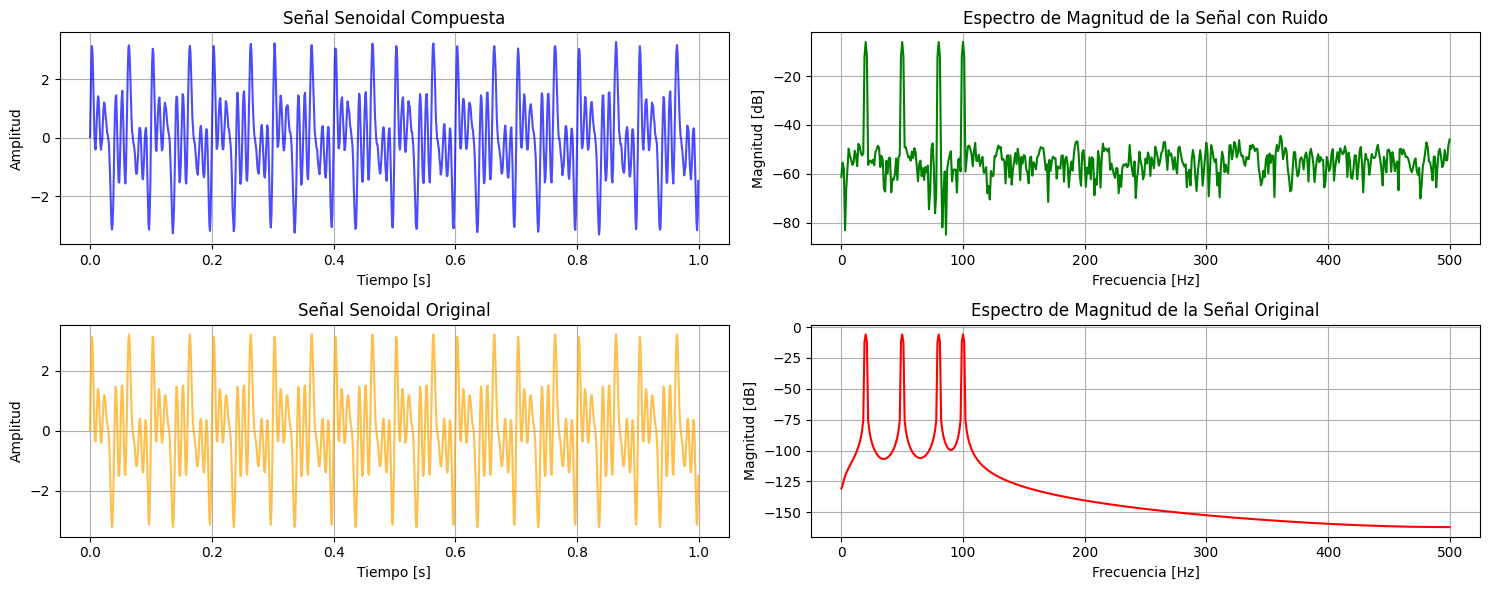

In [2]:
f1 = 20
f2 = 50
f3 = 100
f4 = 80

fs = 1e3
ts = 1/fs
N = 1000
n = np.arange(N)
t = n*ts

noise = np.random.uniform(-0.1, 0.1, N)
phi = np.random.randint(0, 3*np.pi/4)
phi1 = phi
phi2 = phi
phi3 = phi
phi4 = phi

x = np.sin(2*np.pi*f1*n*ts) + np.sin(2*np.pi*f2*n*ts) + np.sin(2*np.pi*f3*n*ts) + np.sin(2*np.pi*f4*n*ts) 
x_noised = np.sin(2*np.pi*f1*n*ts + phi1) + np.sin(2*np.pi*f2*n*ts +phi2) + np.sin(2*np.pi*f3*n*ts + phi3) + np.sin(2*np.pi*f4*n*ts + phi4) + noise

plt.figure(figsize=(15, 6))

plt.subplot(2,2,1)
plt.plot(t, x_noised, label='Señal con Ruido', color='blue', alpha=0.7)
plt.title('Señal Senoidal Compuesta')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.grid()

plt.subplot(2,2,2)
plt.magnitude_spectrum(x_noised, Fs=fs, scale='dB', color='green')
plt.title('Espectro de Magnitud de la Señal con Ruido')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.grid()

plt.subplot(2,2,3)
plt.plot(t, x, label='Señal Original', color='orange', alpha=0.7)
plt.title('Señal Senoidal Original')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.grid()

plt.subplot(2,2,4)
plt.magnitude_spectrum(x, Fs=fs, scale='dB', color='red')
plt.title('Espectro de Magnitud de la Señal Original')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.grid()

plt.tight_layout()
plt.show()

In [3]:
class Gen_DB_sin():
    def __init__(self, f=[20,50,100, 80], fs=1e3, duration=1.0, noise_std=0.02):
        self.f = f
        self.fs = fs
        self.duration = duration
        self.noise_std = noise_std
        self.ts = 1/fs
        self.n_samples = int(fs * duration)
        self.t = np.arange(self.n_samples) * self.ts

    def generate_single_sample(self):
        f1 = self.f[0]
        f2 = self.f[1]
        f3 = self.f[2]
        f4 = self.f[3]

        fs = 1e3
        ts = 1/fs
        N = self.n_samples
        n = np.arange(N)
        t = self.t #n*ts

        noise = np.random.uniform(-0.1, 0.1, N)
        phi = np.random.randint(0, 3*np.pi/4)
        phi1 = phi
        phi2 = phi
        phi3 = phi
        phi4 = phi

        #x = np.sin(2*np.pi*f1*n*ts) + np.sin(2*np.pi*f2*n*ts) + np.sin(2*np.pi*f3*n*ts) + np.sin(2*np.pi*f4*n*ts) 
        x_noised = np.sin(2*np.pi*f1*n*ts + phi1) + np.sin(2*np.pi*f2*n*ts +phi2) + np.sin(2*np.pi*f3*n*ts + phi3) + np.sin(2*np.pi*f4*n*ts + phi4) + noise
        return x_noised
    
    def generate_dataset(self, n_samples):
        X = []
        for _ in range(n_samples):
            x = self.generate_single_sample()
            X.append(x)
        return np.array(X)

In [4]:
Gen_DB_sin_instance = Gen_DB_sin(f=[20,50,100, 80], fs=1e3, duration=1.0, noise_std=0.02)
X_dataset = Gen_DB_sin_instance.generate_dataset(n_samples=1000)

X_dataset

array([[ 3.44637551,  3.78508499,  3.56225536, ..., -0.69032236,
         0.80526016,  2.18433407],
       [-0.03033197,  1.5461192 ,  2.67211186, ..., -3.08711581,
        -2.72904984, -1.54307273],
       [ 3.4487    ,  3.85211911,  3.59806983, ..., -0.71355629,
         0.82517082,  2.21758126],
       ...,
       [ 3.34932946,  3.79650494,  3.63057859, ..., -0.67875309,
         0.79756951,  2.23781472],
       [ 0.06642943,  1.45789897,  2.56988751, ..., -3.17640201,
        -2.61072237, -1.57524383],
       [ 3.43172684,  3.86443835,  3.67420262, ..., -0.51942689,
         0.8037819 ,  2.15860004]])

In [5]:
X_dataset.shape

(1000, 1000)

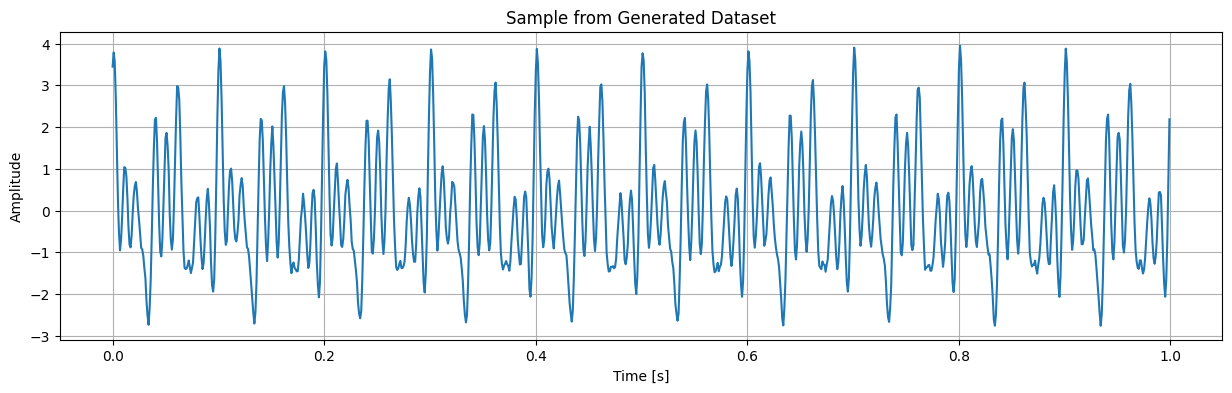

In [6]:
plt.figure(figsize=(15, 4))
plt.plot(Gen_DB_sin_instance.t, X_dataset[0,:])
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Sample from Generated Dataset')
plt.grid()
plt.show()

## Dataloader en batch del dataset  de las señales

In [7]:
import torch
import torch.nn as nn
from torch.optim import Adam, AdamW
from torch.utils.data import DataLoader, Dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed = 2025
torch.manual_seed(seed)
np.random.seed(seed)

class SineWaveDataset:
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx]
    

def get_dataloader(data, batch_size=32, shuffle=True):
    dataset = SineWaveDataset(data)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader


batch_size = 32
dataloader = get_dataloader(X_dataset, batch_size=batch_size, shuffle=True)




## Creación del GAN Vanilla

Minimal improvements (MLP version)

Init: init weights ~𝒩(0,0.02).

Norm: add BatchNorm1d in G (not in D).

Regularization: label smoothing for real (e.g., 0.9), or WGAN-GP for stability.

Capacity: a tad wider helps capture multiple harmonics.

Training tips

Use BCEWithLogitsLoss, Adam(lr=2e-4, betas=(0.5,0.999)), n_critic=1–3.

Normalize real data to [-1,1] (coherente con Tanh).

Early epochs: increase n_critic to help D, then reduce.

Log FFT magnitude of generated vs real; stopping rule: peaks at 20/40/50/100 Hz appear with correct ratios.

In [8]:
# class Generator(nn.Module):
#     def __init__(self, noise_dim=120, output_dim=1000):
#         super(Generator, self).__init__()
#         self.model = nn.Sequential(
#             nn.Linear(noise_dim, 256),
#             nn.ReLU(True),
#             nn.Linear(256, 512),
#             nn.ReLU(True),
#             nn.Linear(512, 1024),
#             nn.ReLU(True),
#             nn.Linear(1024, output_dim),
#             nn.Tanh()
#         )

#     def forward(self, z):
#         return self.model(z)
    
# class Discriminator(nn.Module):
#     def __init__(self, input_dim=1000):
#         super(Discriminator, self).__init__()
#         self.model = nn.Sequential(
#             nn.Linear(input_dim, 512),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Linear(512, 256),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Linear(256, 1),
#             #nn.Sigmoid()
#         )

#     def forward(self, x):
#         return self.model(x)

# Generator (MLP)
# class Generator(nn.Module):
#     def __init__(self, noise_dim=120, output_dim=1000):
#         super().__init__()
#         self.model = nn.Sequential(
#             nn.Linear(noise_dim, 512), nn.BatchNorm1d(512), nn.ReLU(True),
#             nn.Linear(512, 1024),      nn.BatchNorm1d(1024), nn.ReLU(True),
#             nn.Linear(1024, 1024),     nn.BatchNorm1d(1024), nn.ReLU(True),
#             nn.Linear(1024, output_dim),
#             nn.Tanh()
#         )
#     def forward(self, z): return self.model(z)

# # Discriminator (MLP, logits)
# class Discriminator(nn.Module):
#     def __init__(self, input_dim=1000):
#         super().__init__()
#         self.model = nn.Sequential(
#             nn.Linear(input_dim, 512), nn.LeakyReLU(0.2, True),
#             nn.Linear(512, 256),       nn.LeakyReLU(0.2, True),
#             nn.Linear(256, 1)  # logits
#         )
#     def forward(self, x): return self.model(x.view(x.size(0), -1))

# class Generator(nn.Module):
#     def __init__(self, input_dim=100, output_dim=1000):
#         super().__init__()
#         self.proj = nn.Linear(input_dim, 128*125)  # 125*8 ≈ 1000 after upsampling
#         self.net = nn.Sequential(
#             nn.BatchNorm1d(128), nn.ReLU(True),
#             nn.ConvTranspose1d(128, 64, 4, stride=2, padding=1), nn.BatchNorm1d(64), nn.ReLU(True),
#             nn.ConvTranspose1d(64, 32, 4, stride=2, padding=1),  nn.BatchNorm1d(32), nn.ReLU(True),
#             nn.ConvTranspose1d(32, 16, 4, stride=2, padding=1),  nn.BatchNorm1d(16), nn.ReLU(True),
#             nn.Conv1d(16, 1, 3, padding=1), nn.Tanh()
#         )
#         self.output_dim = output_dim
#     def forward(self, z):
#         h = self.proj(z).view(z.size(0), 128, 125)
#         x = self.net(h)
#         return x.squeeze(1)[..., :self.output_dim]

# class Discriminator(nn.Module):
#     def __init__(self):
#         super().__init__(self, input_dim=100)
#         self.net = nn.Sequential(
#             nn.Conv1d(1, 32, 7, 2, 3), nn.LeakyReLU(0.2, True),
#             nn.Conv1d(32,64, 7, 2, 3), nn.LeakyReLU(0.2, True),
#             nn.Conv1d(64,128,7, 2, 3), nn.LeakyReLU(0.2, True),
#             nn.AdaptiveAvgPool1d(1)
#         )
#         self.out = nn.Linear(128, 1)  # logits
#     def forward(self, x):
#         x = x.unsqueeze(1) if x.dim()==2 else x
#         return self.out(self.net(x).squeeze(-1))
    


# class Discriminator(nn.Module):
#     def __init__(self, input_dim=1000):
#         super().__init__()
#         self.input_dim = input_dim  # store for reference
        
#         self.net = nn.Sequential(
#             nn.Conv1d(1, 32, 7, 2, 3),  # (in_channels, out_channels, kernel, stride, padding)
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Conv1d(32, 64, 7, 2, 3),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Conv1d(64, 128, 7, 2, 3),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.AdaptiveAvgPool1d(1)
#         )
        
#         self.out = nn.Linear(128, 1)  # logits for BCEWithLogitsLoss

#     def forward(self, x):
#         # x may come as (B, L) from dataloader or generator
#         if x.dim() == 2:
#             x = x.unsqueeze(1)  # make (B, 1, L)
#         features = self.net(x).squeeze(-1)  # (B, 128)
#         logits = self.out(features)
#         return logits



In [9]:
# class Generator(nn.Module):
#     def __init__(self, input_dim, output_dim):
#         super(Generator, self).__init__()
#         self.model = nn.Sequential(
#             nn.Linear(input_dim, 128),
#             nn.ReLU(),
#             nn.Linear(128, 256),
#             nn.ReLU(),
#             nn.Linear(256, 512),
#             nn.ReLU(),
#             nn.Linear(512, output_dim),
#             nn.Tanh()
#         )
    
#     def forward(self, x):
#         return self.model(x)

# class Discriminator(nn.Module):
#     def __init__(self, input_dim):
#         super(Discriminator, self).__init__()
#         self.model = nn.Sequential(
#             nn.Linear(input_dim, 512),
#             nn.LeakyReLU(0.2),
#             nn.Dropout(0.3),
#             nn.Linear(512, 256),
#             nn.LeakyReLU(0.2),
#             nn.Dropout(0.3),
#             nn.Linear(256, 128),
#             nn.LeakyReLU(0.2),
#             nn.Dropout(0.3),
#             nn.Linear(128, 1)
#         )
    
#     def forward(self, x):
#         return self.model(x)

In [10]:
import torch.nn.utils as nn_utils
import math

# -------------------------
# Utils
# -------------------------
def weights_init_dcgan(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:
        nn.init.normal_(m.weight, 0.0, 0.02)
        if getattr(m, "bias", None) is not None:
            nn.init.zeros_(m.bias)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.zeros_(m.bias)

# Bloque conv 1D simple
def conv1d(in_ch, out_ch, k, s=1, p=None, sn=True):
    if p is None:
        p = (k-1)//2
    layer = nn.Conv1d(in_ch, out_ch, k, stride=s, padding=p)
    return nn_utils.spectral_norm(layer) if sn else layer

# -------------------------
# Generator 1D (upsampling progresivo)
# -------------------------
class Generator1D(nn.Module):
    """
    Genera una señal de longitud L con C canales (por defecto 1).
    Upsampling: interpolate (x2) + Conv1d estabiliza mejor que ConvTranspose1d en 1D.
    """
    def __init__(self, noise_dim=64, out_len=1000, out_channels=1, base_ch=128):
        super().__init__()
        self.out_len = out_len
        # Elegimos un tamaño base tal que base_len * 8 >= out_len
        base_len = math.ceil(out_len / 8)
        self.base_len = base_len

        self.proj = nn.Linear(noise_dim, base_ch * base_len)

        self.net = nn.Sequential(
            nn.BatchNorm1d(base_ch),
            nn.ReLU(inplace=True),

            # x2
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv1d(base_ch, base_ch//2, kernel_size=7, padding=3),
            nn.BatchNorm1d(base_ch//2),
            nn.ReLU(inplace=True),

            # x2
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv1d(base_ch//2, base_ch//4, kernel_size=7, padding=3),
            nn.BatchNorm1d(base_ch//4),
            nn.ReLU(inplace=True),

            # x2  -> base_len * 8 ≳ out_len
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv1d(base_ch//4, base_ch//8, kernel_size=7, padding=3),
            nn.BatchNorm1d(base_ch//8),
            nn.ReLU(inplace=True),

            nn.Conv1d(base_ch//8, out_channels, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        # z: (B, noise_dim)
        x = self.proj(z)                                  # (B, base_ch*base_len)
        # reshape a (B, C, L)
        B = x.size(0)
        # canal base_ch y longitud base_len
        x = x.view(B, -1, self.base_len)                  # (B, base_ch, base_len)
        x = self.net(x)                                   # (B, out_ch, ≳ out_len)
        # recortar exactamente a out_len
        if x.size(-1) != self.out_len:
            x = x[..., :self.out_len]
        return x

# -------------------------
# Discriminator 1D Multiescala (logits)
# -------------------------
class Discriminator1D(nn.Module):
    """
    Ramas paralelas con kernels {3,5,7,11}, concat -> downsample -> GAP -> Linear.
    SpectralNorm en convs para estabilidad. Sin Sigmoid (usar BCEWithLogitsLoss o WGAN-GP).
    """
    def __init__(self, in_len=1000, in_channels=1, base_ch=32):
        super().__init__()
        self.in_len = in_len
        self.in_channels = in_channels

        # Stem opcional (conv+pool ligero) – parecido a tu MaxPooling1D inicial
        self.stem = nn.Sequential(
            conv1d(in_channels, base_ch, k=3, s=1, sn=True),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # Ramas multiescala
        self.branch3  = nn.Sequential(conv1d(base_ch, base_ch, k=3, s=1),  nn.LeakyReLU(0.2, True))
        self.branch5  = nn.Sequential(conv1d(base_ch, base_ch, k=5, s=1),  nn.LeakyReLU(0.2, True))
        self.branch7  = nn.Sequential(conv1d(base_ch, base_ch, k=7, s=1),  nn.LeakyReLU(0.2, True))
        self.branch11 = nn.Sequential(conv1d(base_ch, base_ch, k=11, s=1), nn.LeakyReLU(0.2, True))

        # Concat -> 4*base_ch canales
        concat_ch = base_ch * 4

        # Downsampling en etapas para capturar estructura a distintas escalas
        self.down = nn.Sequential(
            conv1d(concat_ch, 2*base_ch, k=7, s=2), nn.LeakyReLU(0.2, True),
            conv1d(2*base_ch, 4*base_ch, k=7, s=2), nn.LeakyReLU(0.2, True),
            conv1d(4*base_ch, 4*base_ch, k=7, s=2), nn.LeakyReLU(0.2, True),
        )

        self.gap = nn.AdaptiveAvgPool1d(1)
        self.out = nn.Linear(4*base_ch, 1)  # logits

    def forward(self, x):
        # x: (B, C, L) o (B, L) -> ajustamos
        if x.dim() == 2:
            x = x.unsqueeze(1)             # (B,1,L)
        x = self.stem(x)                   # (B, base_ch, L)

        b3  = self.branch3(x)
        b5  = self.branch5(x)
        b7  = self.branch7(x)
        b11 = self.branch11(x)
        h = torch.cat([b3, b5, b7, b11], dim=1)  # (B, 4*base_ch, L)

        h = self.down(h)                   # (B, 4*base_ch, L/8 aprox.)
        h = self.gap(h).squeeze(-1)        # (B, 4*base_ch)
        logits = self.out(h)               # (B, 1)
        return logits


Epoch [20/1000], D Loss: 0.0144, G Loss: 4.7757
Epoch [40/1000], D Loss: 0.0028, G Loss: 6.4239
Epoch [60/1000], D Loss: 0.0012, G Loss: 7.2418
Epoch [80/1000], D Loss: 0.0006, G Loss: 7.9985
Epoch [100/1000], D Loss: 0.0003, G Loss: 8.6134


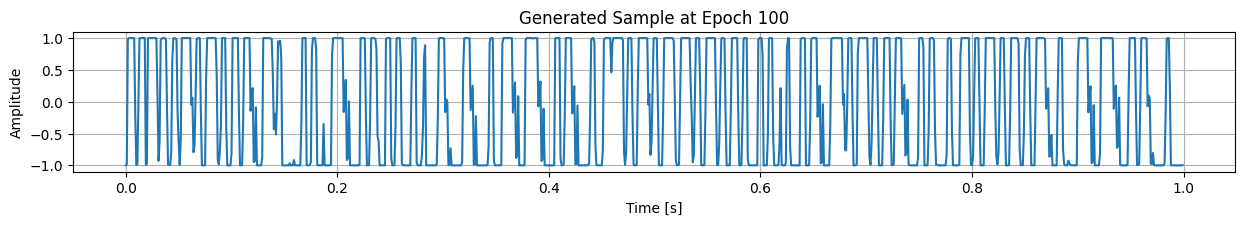

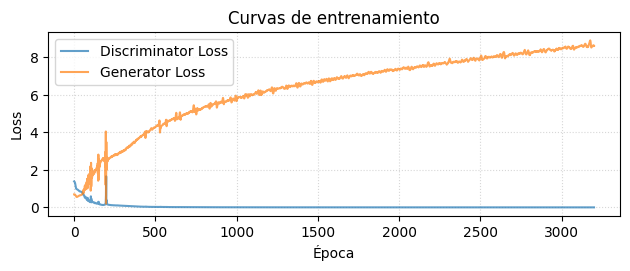

Epoch [120/1000], D Loss: 0.0002, G Loss: 9.2858
Epoch [140/1000], D Loss: 0.0001, G Loss: 9.8399
Epoch [160/1000], D Loss: 0.0001, G Loss: 10.3206
Epoch [180/1000], D Loss: 0.0000, G Loss: 10.7587
Epoch [200/1000], D Loss: 0.0000, G Loss: 11.2851


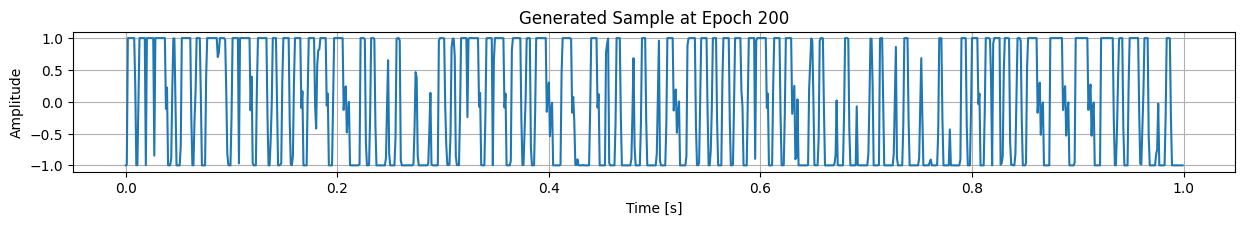

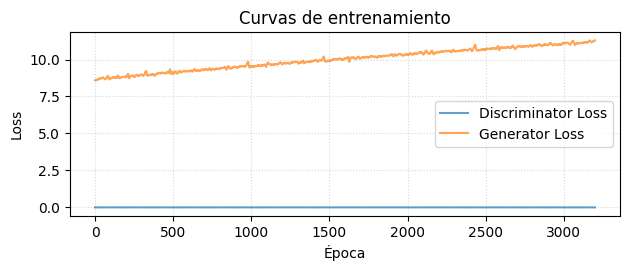

Epoch [220/1000], D Loss: 0.0000, G Loss: 11.6081
Epoch [240/1000], D Loss: 0.0000, G Loss: 12.0458
Epoch [260/1000], D Loss: 0.0000, G Loss: 12.4367
Epoch [280/1000], D Loss: 0.0000, G Loss: 12.7699
Epoch [300/1000], D Loss: 0.0000, G Loss: 13.2196


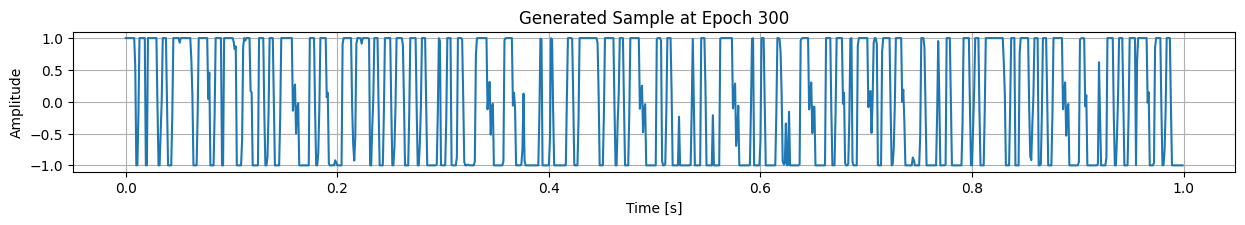

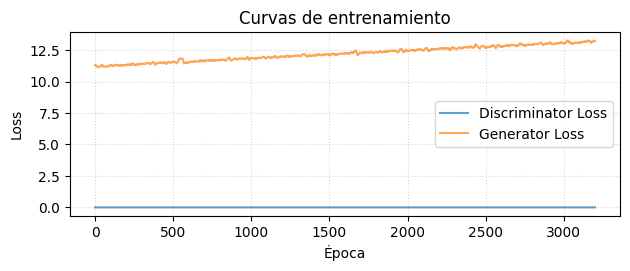

Epoch [320/1000], D Loss: 0.0000, G Loss: 13.5997
Epoch [340/1000], D Loss: 0.0000, G Loss: 13.9091
Epoch [360/1000], D Loss: 0.0000, G Loss: 14.3143
Epoch [380/1000], D Loss: 0.0000, G Loss: 14.6787
Epoch [400/1000], D Loss: 0.0000, G Loss: 15.0975


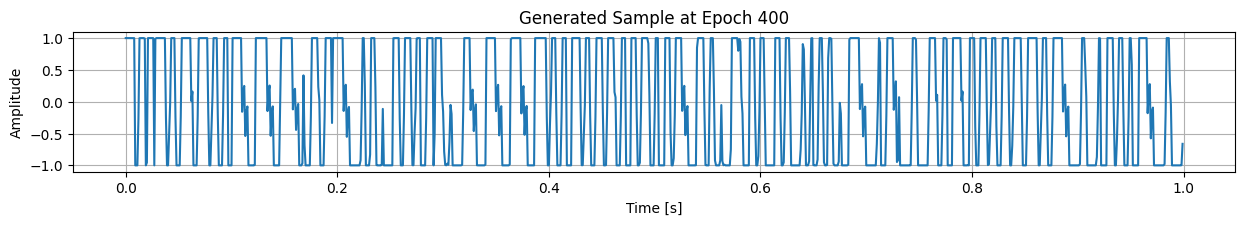

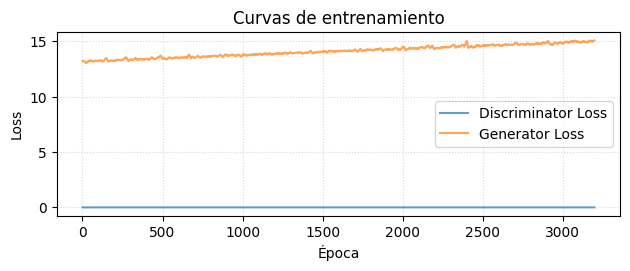

Epoch [420/1000], D Loss: 0.0000, G Loss: 15.3264
Epoch [440/1000], D Loss: 0.0000, G Loss: 15.6433
Epoch [460/1000], D Loss: 0.0000, G Loss: 16.1626
Epoch [480/1000], D Loss: 0.0000, G Loss: 16.3358
Epoch [500/1000], D Loss: 0.0000, G Loss: 17.0006


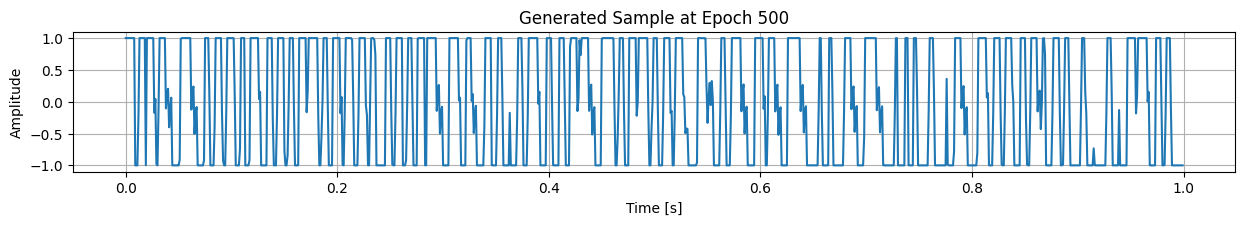

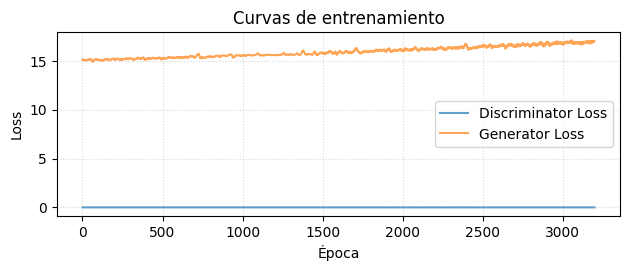

Epoch [520/1000], D Loss: 0.0000, G Loss: 17.3098
Epoch [540/1000], D Loss: 0.0000, G Loss: 17.0714
Epoch [560/1000], D Loss: 0.0000, G Loss: 17.9388
Epoch [580/1000], D Loss: 0.0000, G Loss: 17.9984
Epoch [600/1000], D Loss: 0.0000, G Loss: 19.0742


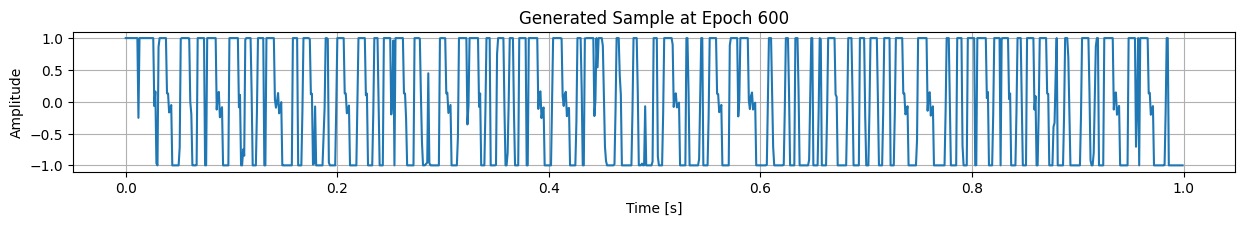

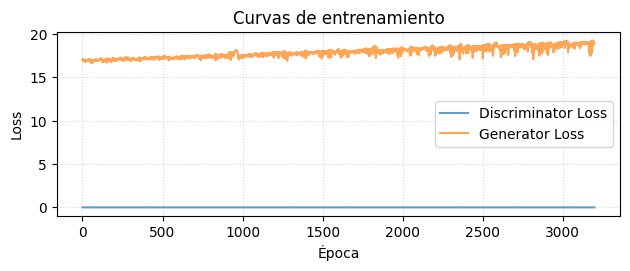

Epoch [620/1000], D Loss: 0.0000, G Loss: 19.3548
Epoch [640/1000], D Loss: 0.0000, G Loss: 19.5879
Epoch [660/1000], D Loss: 0.0000, G Loss: 19.7049
Epoch [680/1000], D Loss: 0.0000, G Loss: 20.0582
Epoch [700/1000], D Loss: 0.0000, G Loss: 20.9386


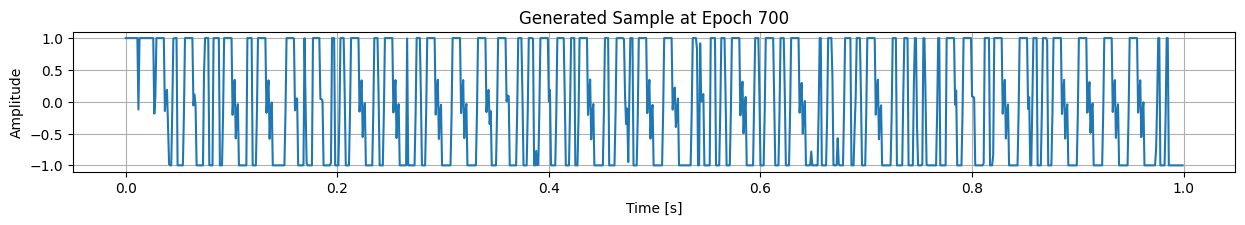

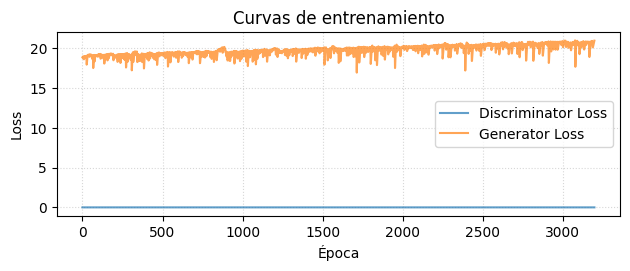

Epoch [720/1000], D Loss: 0.0000, G Loss: 19.5204
Epoch [740/1000], D Loss: 0.0000, G Loss: 21.6911
Epoch [760/1000], D Loss: 0.0000, G Loss: 21.8613
Epoch [780/1000], D Loss: 0.0000, G Loss: 21.7607
Epoch [800/1000], D Loss: 0.0000, G Loss: 22.5353


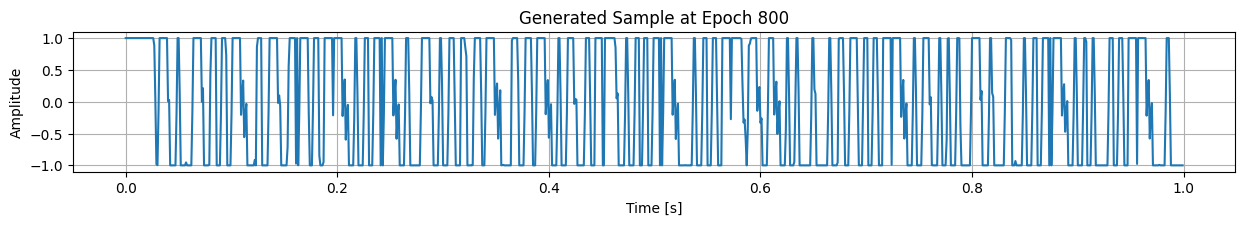

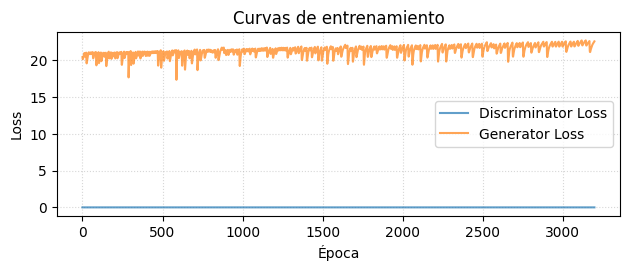

Epoch [820/1000], D Loss: 0.0000, G Loss: 22.3014
Epoch [840/1000], D Loss: 0.0000, G Loss: 22.6706
Epoch [860/1000], D Loss: 0.0000, G Loss: 23.2622
Epoch [880/1000], D Loss: 0.0000, G Loss: 22.5207
Epoch [900/1000], D Loss: 0.0000, G Loss: 22.8795


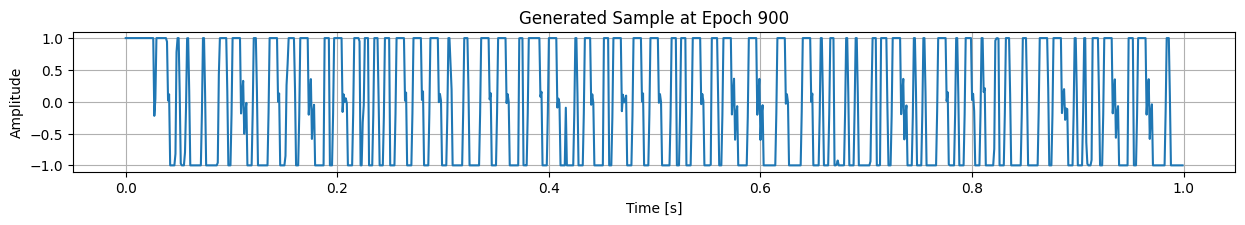

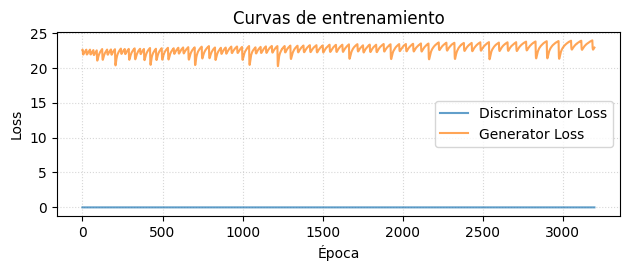

Epoch [920/1000], D Loss: 0.0000, G Loss: 23.6656
Epoch [940/1000], D Loss: 0.0000, G Loss: 23.8480
Epoch [960/1000], D Loss: 0.0000, G Loss: 23.9530
Epoch [980/1000], D Loss: 0.0000, G Loss: 24.1338
Epoch [1000/1000], D Loss: 0.0000, G Loss: 24.7338


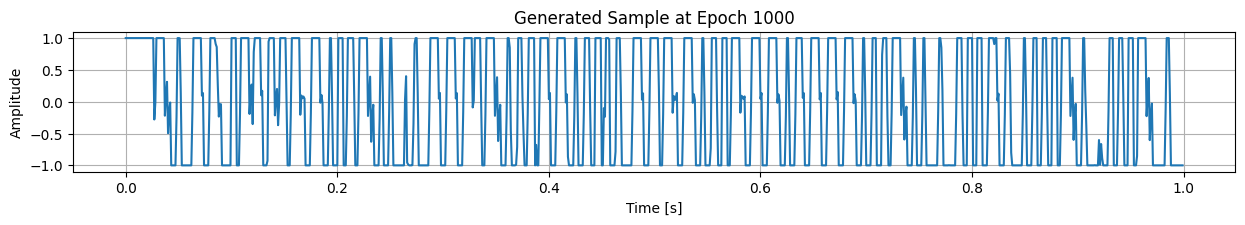

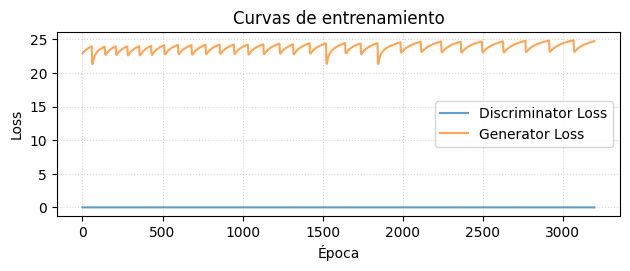

***************** Training finished!!! ****************


In [11]:

class Trainer:
    def __init__(self, generator, discriminator, g_optimizer, d_optimizer, criterion, device, noise_dim):
        self.generator = generator
        self.discriminator = discriminator
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.criterion = criterion
        self.device = device
        self.noise_dim = noise_dim

    def train_step(self, real_data):
        batch_size = real_data.size(0)
        real_data = real_data.to(self.device)

        # Train Discriminator
        self.d_optimizer.zero_grad()

        # Real data
        real_labels = torch.ones(batch_size, 1).to(self.device)
        real_outputs = self.discriminator(real_data)
        d_loss_real = self.criterion(real_outputs, real_labels)

        # Fake data
        noise = torch.randn(batch_size, self.noise_dim).to(self.device)
        fake_data = self.generator(noise)
        fake_labels = torch.zeros(batch_size, 1).to(self.device)
        fake_outputs = self.discriminator(fake_data.detach())
        d_loss_fake = self.criterion(fake_outputs, fake_labels)

        # Total discriminator loss
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        self.d_optimizer.step()

        # Train Generator
        self.g_optimizer.zero_grad()
        fake_outputs = self.discriminator(fake_data)
        g_loss = self.criterion(fake_outputs, real_labels)
        g_loss.backward()
        self.g_optimizer.step()

        return d_loss.item(), g_loss.item()

## Creacion del GAN vanilla
noise_dim = 64
output_dim = X_dataset.shape[1]

generator =  Generator1D(noise_dim=64, out_len=1000, out_channels=1, base_ch=128).to(device)
discriminator = Discriminator1D(in_len=1000, in_channels=1, base_ch=32).to(device)
generator.apply(weights_init_dcgan)
discriminator.apply(weights_init_dcgan)

g_optimizer = Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCEWithLogitsLoss()

trainer = Trainer(generator, discriminator, g_optimizer, d_optimizer, criterion, device, noise_dim)

num_epochs = 1000
num_epochs = 1000
g_errors = []
d_errors = []


EPOCHS_TO_PLOT = 100
LOSS_MAX_VIEW = batch_size * EPOCHS_TO_PLOT

for epoch in range(num_epochs):
    for real_data in dataloader:
        d_loss, g_loss = trainer.train_step(real_data)
        d_errors.append(d_loss)
        g_errors.append(g_loss)

    if (epoch+1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}')

    if (epoch+1) % EPOCHS_TO_PLOT == 0:
        plt.figure(figsize=(15, 4))
        generator.eval()  # Set to evaluation mode
        with torch.no_grad():
            noise = torch.randn(1, noise_dim).to(device)
            generated_data = generator(noise).cpu().detach().numpy().reshape(-1)
        generator.train()  # Set back to training mode

        # Generate sample for visualization
        noise = torch.randn(1, noise_dim).to(device)
        generated_data = generator(noise).cpu().detach().numpy().reshape(-1)

        plt.subplot(2, 1, 1)
        plt.plot(Gen_DB_sin_instance.t, generated_data)
        plt.xlabel('Time [s]')
        plt.ylabel('Amplitude')
        plt.title(f'Generated Sample at Epoch {epoch+1}')
        plt.grid()
        plt.show()

         # Graficar curvas de pérdida
        plt.subplot(2, 1, 2)
        plt.plot(d_errors[len(d_errors)-LOSS_MAX_VIEW:], label='Discriminator Loss', alpha=0.7)
        plt.plot(g_errors[len(g_errors)-LOSS_MAX_VIEW:], label='Generator Loss', alpha=0.7)
        plt.xlabel('Época')
        plt.ylabel('Loss')
        plt.title('Curvas de entrenamiento')
        plt.legend()
        plt.grid(ls=":", alpha=0.5)
        
        plt.tight_layout()
        plt.show()

print("***************** Training finished!!! ****************")


## Test nueva data generada

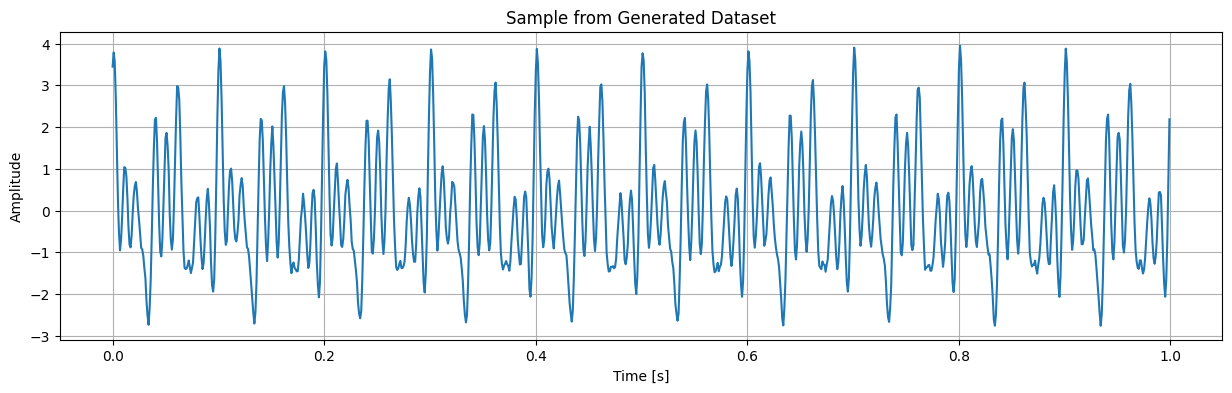

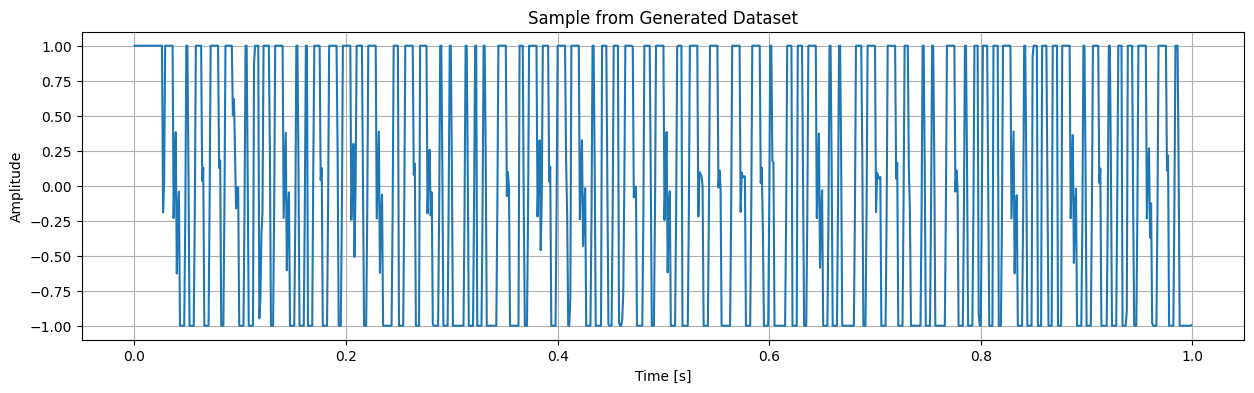

In [12]:
plt.figure(figsize=(15, 4))
plt.plot(Gen_DB_sin_instance.t, X_dataset[0,:])
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Sample from Generated Dataset')
plt.grid()
plt.show()

noise = torch.randn(1, noise_dim).to(device)
generated_data2 = generator(noise).cpu().detach().numpy().reshape(-1)


plt.figure(figsize=(15, 4))
plt.plot(Gen_DB_sin_instance.t, generated_data2)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Sample from Generated Dataset')
plt.grid()
plt.show()